In [2]:
import pandas as pd 
import numpy as np 
# Load AIS data 
ais_data = pd.read_csv("ais_dataset.csv")  # Replace with actual file path 
# Load each emission factor file 
propulsion_factors = pd.read_csv("propulsion_engine_emission_factors.csv") 
boiler_factors = pd.read_csv("boiler_engine_emission_factors.csv") 
auxiliary_factors = pd.read_csv("auxiliary_engine_emission_factors.csv") 
# Add a column to identify engine type 
propulsion_factors["engine_type"] = "propulsion" 
boiler_factors["engine_type"] = "boiler" 
auxiliary_factors["engine_type"] = "auxiliary" 
# Combine all emission factor files into one DataFrame 
emission_factors = pd.concat([propulsion_factors, boiler_factors, auxiliary_factors], ignore_index=True) 
# Display the combined data 
print(emission_factors.head()) 
# Step 1: Merge AIS data with emission factors based on vessel type or ID 
merged_data = ais_data.merge(emission_factors, on="vessel_type")  # Adjust 'vessel_type' as per your dataset 
# Step 2: Calculate total time in anchorage (hours) 
merged_data["anchorage_time_hours"] = (pd.to_datetime(merged_data["departure_time"]) -  
                                       pd.to_datetime(merged_data["arrival_time"])).dt.total_seconds() / 3600 
# Step 3: Calculate emissions for each vessel 
merged_data["emission_before_jit"] = (merged_data["fuel_consumption_rate"] *  
                                      merged_data["anchorage_time_hours"] *  
                                      merged_data["emission_factor"]) 
# Step 4: Aggregate emissions 
anc_before_jit = merged_data["emission_before_jit"].sum() 
print(f"Total CO2 emissions before JIT: {anc_before_jit} tonnes")


                                  fuel  fuel_category sulfur engine_type  \
0  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
1  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
2  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
3  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   
4  HFO (outside ECA and prior to 2020)              1  2.70%  propulsion   

   emission_tier model_years   nox  pm10  pm2_5    voc     sox   n2_O   ch4  \
0            0.0    Pre-2000  18.1  1.42   1.31  0.632  10.293  0.031  0.01   
1            1.0   2000-2010  17.0  1.42   1.31  0.632  10.293  0.031  0.01   
2            2.0   post 2010  15.3  1.42   1.31  0.632  10.293  0.031  0.01   
3            0.0    Pre-2000  14.0  1.43   1.32  0.530  11.244  0.030  0.01   
4            1.0   2000-2010  13.0  1.43   1.32  0.530  11.244  0.030  0.01   

    sfoc  n_ox  bsfc engine_size  s_ox  n2_o  
0  195.0   NaN   NaN 

KeyError: 'vessel_type'

In [28]:
import pandas as pd

# Load datasets
ais_data = pd.read_csv('ais_dataset.csv')
aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')

# Filter engine factors for matching fuel_category
aux_engine_factors = aux_engine_factors[aux_engine_factors['fuel_category'] == 2]
boiler_engine_factors = boiler_engine_factors[boiler_engine_factors['fuel_category'] == 2]

# Step 1: Filter for anchorage events
anchorage_data = ais_data[(ais_data['speed'] < 1) & (ais_data['anchorage'] == 1)].copy()

# Step 2: Convert 'timestamp' to datetime and drop invalid rows
anchorage_data['timestamp'] = pd.to_datetime(anchorage_data['timestamp'], errors='coerce')
anchorage_data.dropna(subset=['timestamp'], inplace=True)

# Filter for July
july_data = anchorage_data[anchorage_data['timestamp'].dt.month == 7]

# Step 3: Merge datasets on 'fuel_category'
print("Before merge:", july_data.shape)
aux_merged = pd.merge(july_data, aux_engine_factors, on='fuel_category', how='left')
print("After auxiliary merge:", aux_merged.shape)
boiler_merged = pd.merge(aux_merged, boiler_engine_factors, on='fuel_category', how='left')
print("After boiler merge:", boiler_merged.shape)

# Step 4: Calculate emissions
boiler_merged['activity_duration_hours'] = (
    boiler_merged['timestamp'].diff().dt.total_seconds() / 3600
)
boiler_merged['aux_emissions'] = (
    boiler_merged['ael'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_x']
)
boiler_merged['boiler_emissions'] = (
    boiler_merged['abl'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_y']
)
boiler_merged['total_emissions'] = (
    boiler_merged['aux_emissions'] + boiler_merged['boiler_emissions']
)

# Step 5: Aggregate emissions for July
july_emissions = boiler_merged.groupby('imo')['total_emissions'].sum().reset_index()
july_emissions.columns = ['imo', 'anc_before_jit']
july_emissions['anc_before_jit'] /= 1000  # Convert grams to tonnes

# Save the results
print(july_emissions)
july_emissions.to_csv('anc_before_jit.csv', index=False)


Before merge: (0, 30)
After auxiliary merge: (0, 43)
After boiler merge: (0, 53)
Empty DataFrame
Columns: [imo, anc_before_jit]
Index: []


In [10]:
print(ais_data.columns)


Index(['imo', 'mmsi', 'vessel_name', 'date_of_build', 'vessel_type', 'group',
       'timestamp', 'lon', 'lat', 'nav_stat', 'speed', 'course', 'heading',
       'fuel_category', 'main_engine_fuel_type', 'aux_engine_fuel_type',
       'engine_type', 'berth', 'port_name', 'anchorage', 'terminal',
       'maneuvering_zone', 'p', 'vref', 'sfc_me', 'sfc_ae', 'sfc_ab', 'ael',
       'abl', 'distance'],
      dtype='object')


In [18]:
print(ais_data['timestamp'].head())
print(ais_data['timestamp'].dtype)







0    2024-07-28T00:23:32.000Z
1    2024-07-28T00:25:02.000Z
2    2024-07-28T00:30:01.000Z
3    2024-07-28T00:32:51.000Z
4    2024-07-28T00:35:02.000Z
Name: timestamp, dtype: object
object


In [20]:
print("AIS Data Columns:", ais_data.columns)
print("Auxiliary Engine Factors Columns:", aux_engine_factors.columns)
print("Boiler Engine Factors Columns:", boiler_engine_factors.columns)


AIS Data Columns: Index(['imo', 'mmsi', 'vessel_name', 'date_of_build', 'vessel_type', 'group',
       'timestamp', 'lon', 'lat', 'nav_stat', 'speed', 'course', 'heading',
       'fuel_category', 'main_engine_fuel_type', 'aux_engine_fuel_type',
       'engine_type', 'berth', 'port_name', 'anchorage', 'terminal',
       'maneuvering_zone', 'p', 'vref', 'sfc_me', 'sfc_ae', 'sfc_ab', 'ael',
       'abl', 'distance'],
      dtype='object')
Auxiliary Engine Factors Columns: Index(['fuel', 'fuel_category', 'sulfur', 'engine_size', 'emission_tier',
       'model_years', 'nox', 'pm10', 'pm2_5', 'voc', 's_ox', 'n2_o', 'ch4',
       'bsfc'],
      dtype='object')
Boiler Engine Factors Columns: Index(['fuel', 'fuel_category', 'sulfur', 'n_ox', 'pm10', 'pm2_5', 'voc',
       'sox', 'n2_O', 'ch4', 'bsfc'],
      dtype='object')


In [23]:
print(ais_data['fuel_category'].unique())
print(aux_engine_factors['fuel_category'].unique())
print(boiler_engine_factors['fuel_category'].unique())


[2]
[1 2 3]
[1 2 3]


In [24]:
print("Before merge:", july_data.shape)
aux_merged = pd.merge(july_data, aux_engine_factors, on='fuel_category', how='left')
print("After auxiliary merge:", aux_merged.shape)
boiler_merged = pd.merge(aux_merged, boiler_engine_factors, on='fuel_category', how='left')
print("After boiler merge:", boiler_merged.shape)


Before merge: (0, 30)
After auxiliary merge: (0, 43)
After boiler merge: (0, 53)


In [31]:
print("Fuel categories in July data:", july_data['fuel_category'].unique())


Fuel categories in July data: []


In [32]:
anchorage_data = ais_data[ais_data['anchorage'].notnull()].copy()


In [35]:
july_data = anchorage_data[anchorage_data['timestamp'].dt.month == 7]


In [ ]:
anchorage_data = ais_data[ais_data['anchorage'].notnull()].copy()


In [38]:
import pandas as pd

# Load datasets
ais_data = pd.read_csv('ais_dataset.csv')
aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')

# Step 1: Filter for anchorage events
anchorage_data = ais_data[ais_data['anchorage'].str.contains('Anchorage Zone', na=False)].copy()
anchorage_data['timestamp'] = pd.to_datetime(anchorage_data['timestamp'], errors='coerce')
anchorage_data.dropna(subset=['timestamp'], inplace=True)

# Step 2: Filter for July
july_data = anchorage_data[anchorage_data['timestamp'].dt.month == 7]
print("Unique IMO in July data before merge:", july_data['imo'].nunique())

# Step 3: Ensure all relevant fuel categories are covered
relevant_fuel_categories = july_data['fuel_category'].unique()
aux_engine_factors = aux_engine_factors[aux_engine_factors['fuel_category'].isin(relevant_fuel_categories)]
boiler_engine_factors = boiler_engine_factors[boiler_engine_factors['fuel_category'].isin(relevant_fuel_categories)]

# Step 4: Perform outer merges to retain all rows
aux_merged = pd.merge(july_data, aux_engine_factors, on='fuel_category', how='outer')
print("Unique IMO after auxiliary merge:", aux_merged['imo'].nunique())

boiler_merged = pd.merge(aux_merged, boiler_engine_factors, on='fuel_category', how='outer')
print("Unique IMO after boiler merge:", boiler_merged['imo'].nunique())

# Step 5: Fill missing values with defaults
boiler_merged['activity_duration_hours'] = (
    boiler_merged['timestamp'].diff().dt.total_seconds() / 3600
).fillna(0)
boiler_merged['ael'] = boiler_merged['ael'].fillna(0)
boiler_merged['abl'] = boiler_merged['abl'].fillna(0)
boiler_merged['bsfc_x'] = boiler_merged['bsfc_x'].fillna(0)
boiler_merged['bsfc_y'] = boiler_merged['bsfc_y'].fillna(0)

# Auxiliary engine emissions: E = L_A * A * EF
boiler_merged['aux_emissions'] = (
    boiler_merged['ael'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_x']
)

# Boiler emissions: E = L_B * A * EF
boiler_merged['boiler_emissions'] = (
    boiler_merged['abl'] * boiler_merged['activity_duration_hours'] * boiler_merged['bsfc_y']
)

# Total emissions at anchorage
boiler_merged['total_emissions'] = (
    boiler_merged['aux_emissions'] + boiler_merged['boiler_emissions']
)

# Step 6: Aggregate emissions for July
july_emissions = boiler_merged.groupby('imo')['total_emissions'].sum().reset_index()
july_emissions.columns = ['imo', 'anc_before_jit']
july_emissions['anc_before_jit'] /= 1000  # Convert grams to tonnes

# Fill missing IMOs with placeholders (if any)
july_emissions['imo'] = july_emissions['imo'].fillna('Unknown')

# Save results
print("Final emissions data:")
print(july_emissions.head())
july_emissions.to_csv('anc_before_jit_uncleansed.csv', index=False)


Unique IMO in July data before merge: 2337
Unique IMO after auxiliary merge: 2337
Unique IMO after boiler merge: 2337
Final emissions data:
       imo  anc_before_jit
0  1013315   -17009.030660
1  1014838    -6457.638222
2  1015820    24836.123125
3  1017775     6518.825733
4  1018547    99971.276731


In [39]:
print("Unique IMO in final output:", july_emissions['imo'].nunique())


Unique IMO in final output: 2337


In [47]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Convert timestamp to datetime format
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

    # Drop rows with missing or invalid values
    data.dropna(subset=['latitude', 'longitude', 'speed', 'vesselType'], inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    
    # Add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# Determine optimal number of clusters using the elbow method
def find_optimal_clusters(features, max_clusters=10):
    inertia = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features)
        inertia.append(kmeans.inertia_)
    
    # Detect the elbow point
    kneedle = KneeLocator(range(1, max_clusters + 1), inertia, curve="convex", direction="decreasing")
    optimal_k = kneedle.knee

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f"Optimal Clusters: {optimal_k}")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal Clusters')
    plt.legend()
    plt.show()

    return optimal_k

# Plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('Vessel Clusters')
    plt.show()

# Main function to determine vessel groups
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Determine the optimal number of clusters
    print("Determining optimal number of clusters...")
    optimal_k = find_optimal_clusters(features, max_clusters=10)
    print(f"Optimal number of clusters: {optimal_k}")

    # Step 5: Perform clustering
    print("Performing clustering...")
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=optimal_k)

    # Step 6: Merge clusters back into original data
    data['Cluster'] = clustered_features['Cluster']

    # Step 7: Visualize clusters
    plot_clusters(clustered_features)

    # Save clustered data to a CSV file
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered data saved to 'clustered_vessel_data.csv'")



In [45]:
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Determine the optimal number of clusters
    print("Determining optimal number of clusters...")
    optimal_k = find_optimal_clusters(features, max_clusters=10)
    print(f"Optimal number of clusters: {optimal_k}")

    # Step 5: Perform clustering
    print("Performing clustering...")
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=optimal_k)

    # Step 6: Merge clusters back into original data
    data['Cluster'] = clustered_features['Cluster']

    # Step 7: Visualize clusters
    plot_clusters(clustered_features)

    # Save clustered data to a CSV file
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered data saved to 'clustered_vessel_data.csv'")


In [48]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Ensure consistent column names and clean data
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

    # Drop rows with missing or invalid values
    data.dropna(subset=['Latitude', 'Longitude', 'Speed', 'VesselType'], inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['Latitude', 'Longitude', 'Speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # Add cluster labels to the dataset
    features['Cluster'] = clusters
    return features, kmeans

# Main function to return clustered DataFrame
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # Step 5: Add cluster labels back to original data
    data['Cluster'] = clustered_features['Cluster'].values

    # Step 6: Return the clustered DataFrame
    return data

# Run the function to get the clustered DataFrame
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# Save the clustered DataFrame to a CSV file
clustered_df.to_csv('clustered_vessel_data.csv', index=False)
print("Clustered DataFrame saved to 'clustered_vessel_data.csv'")

# Print a sample of the clustered DataFrame
print(clustered_df.head())


KeyError: 'Timestamp'

In [49]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['Timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['Timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # Drop rows with missing or invalid values
    data.dropna(subset=['Latitude', 'Longitude', 'Speed', 'VesselType'], inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['Latitude', 'Longitude', 'Speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # Add cluster labels to the dataset
    features['Cluster'] = clusters
    return features, kmeans

# Plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['Longitude'], features['Latitude'], c=features['Cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Vessel Clusters')
    plt.show()

# Main function to return clustered DataFrame
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # Step 5: Add cluster labels back to original data
    data['Cluster'] = clustered_features['Cluster'].values

    # Step 6: Visualize clusters
    plot_clusters(clustered_features)

    # Step 7: Save and return the clustered DataFrame
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered DataFrame saved to 'clustered_vessel_data.csv'")

    return data

# Run the function to get the clustered DataFrame
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# Print a sample of the clustered DataFrame
print(clustered_df.head())


KeyError: ['Latitude', 'Longitude', 'Speed', 'VesselType']

In [50]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load AIS dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# Preprocess the dataset
def preprocess_data(data):
    # Dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['Timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['Timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # Check if required columns exist
    required_columns = ['Latitude', 'Longitude', 'Speed', 'VesselType']
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    # Drop rows with missing or invalid values
    data.dropna(subset=required_columns, inplace=True)

    return data.copy()

# Extract relevant features for clustering
def extract_features(data):
    # Select numerical features for clustering
    features = data[['Latitude', 'Longitude', 'Speed']].copy()
    return features

# Perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # Add cluster labels to the dataset
    features['Cluster'] = clusters
    return features, kmeans

# Plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['Longitude'], features['Latitude'], c=features['Cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Vessel Clusters')
    plt.show()

# Main function to return clustered DataFrame
def main(file_path):
    # Step 1: Load data
    data = load_data(file_path)

    # Step 2: Preprocess data
    data = preprocess_data(data)

    # Step 3: Extract features for clustering
    features = extract_features(data)

    # Step 4: Perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # Step 5: Add cluster labels back to original data
    data['Cluster'] = clustered_features['Cluster'].values

    # Step 6: Visualize clusters
    plot_clusters(clustered_features)

    # Step 7: Save and return the clustered DataFrame
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("Clustered DataFrame saved to 'clustered_vessel_data.csv'")

    return data

# Run the function to get the clustered DataFrame
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# Print a sample of the clustered DataFrame
print(clustered_df.head())

KeyError: "Missing required columns: ['Latitude', 'Longitude', 'Speed', 'VesselType']"

In [51]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# load ais dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# preprocess the dataset
def preprocess_data(data):
    # dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # check if required columns exist
    required_columns = ['latitude', 'longitude', 'speed', 'vesseltype']
    missing_columns = [col for col in required_columns if col not in data.columns]
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    # drop rows with missing or invalid values
    data.dropna(subset=required_columns, inplace=True)

    return data.copy()

# extract relevant features for clustering
def extract_features(data):
    # select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('vessel clusters')
    plt.show()

# main function to return clustered dataframe
def main(file_path):
    # step 1: load data
    data = load_data(file_path)

    # step 2: preprocess data
    data = preprocess_data(data)

    # step 3: extract features for clustering
    features = extract_features(data)

    # step 4: perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # step 5: add cluster labels back to original data
    data['cluster'] = clustered_features['cluster'].values

    # step 6: visualize clusters
    plot_clusters(clustered_features)

    # step 7: save and return the clustered dataframe
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("clustered dataframe saved to 'clustered_vessel_data.csv'")

    return data

# run the function to get the clustered dataframe
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# print a sample of the clustered dataframe
print(clustered_df.head())


KeyError: "Missing required columns: ['latitude', 'longitude', 'vesseltype']"

In [52]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# load ais dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# preprocess the dataset
def preprocess_data(data):
    # dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # dynamically handle latitude, longitude, speed, and vessel type column names
    column_mappings = {
        'latitude': next((col for col in data.columns if 'latitude' in col.lower()), None),
        'longitude': next((col for col in data.columns if 'longitude' in col.lower()), None),
        'speed': next((col for col in data.columns if 'speed' in col.lower()), None),
        'vesseltype': next((col for col in data.columns if 'vesseltype' in col.lower()), None)
    }

    # check for missing required columns
    missing_columns = [key for key, value in column_mappings.items() if value is None]
    if missing_columns:
        raise KeyError(f"Missing required columns: {missing_columns}")

    # rename columns to standard names for consistency
    data.rename(columns=column_mappings, inplace=True)

    # drop rows with missing or invalid values
    data.dropna(subset=['latitude', 'longitude', 'speed', 'vesseltype'], inplace=True)

    return data.copy()

# extract relevant features for clustering
def extract_features(data):
    # select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('vessel clusters')
    plt.show()

# main function to return clustered dataframe
def main(file_path):
    # step 1: load data
    data = load_data(file_path)

    # step 2: preprocess data
    data = preprocess_data(data)

    # step 3: extract features for clustering
    features = extract_features(data)

    # step 4: perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # step 5: add cluster labels back to original data
    data['cluster'] = clustered_features['cluster'].values

    # step 6: visualize clusters
    plot_clusters(clustered_features)

    # step 7: save and return the clustered dataframe
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("clustered dataframe saved to 'clustered_vessel_data.csv'")

    return data

# run the function to get the clustered dataframe
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# print a sample of the clustered dataframe
print(clustered_df.head())


KeyError: "Missing required columns: ['latitude', 'longitude', 'vesseltype']"

c:\Users\miche\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


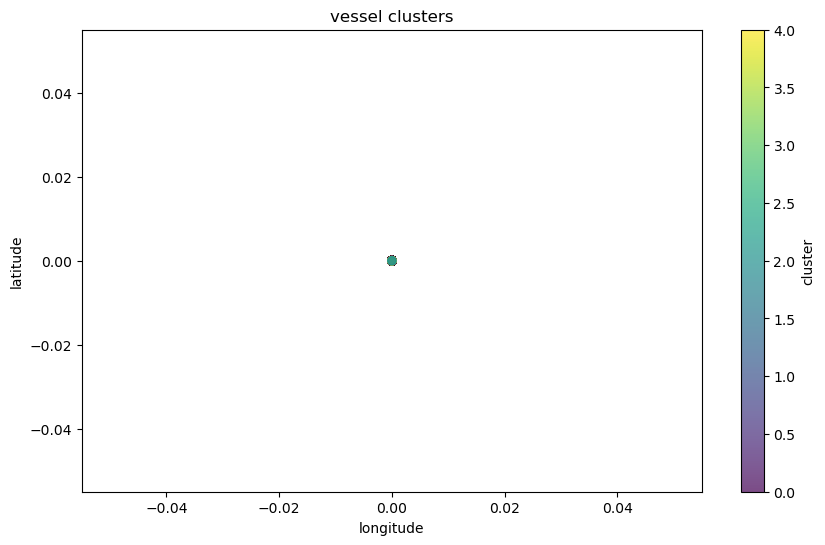

clustered dataframe saved to 'clustered_vessel_data.csv'
       imo       mmsi     vessel_name             date_of_build    vesseltype  \
1  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
2  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
3  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
4  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   
5  9984730  636023994  SEACON ANTWERP  2024-06-06T00:00:00.000Z  Bulk Carrier   

          group                 timestamp         lon       lat  nav_stat  \
1  Bulk Carrier 2024-07-28 00:25:02+00:00  104.029755  1.285643         0   
2  Bulk Carrier 2024-07-28 00:30:01+00:00  104.029420  1.291690         0   
3  Bulk Carrier 2024-07-28 00:32:51+00:00  104.028160  1.294758         0   
4  Bulk Carrier 2024-07-28 00:35:02+00:00  104.026474  1.296387         0   
5  Bulk Carrier 2024-07-28 00:35:52+00:00  104.025780  1.296852        

In [53]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# load ais dataset
def load_data(file_path):
    return pd.read_csv(file_path)

# preprocess the dataset
def preprocess_data(data):
    # dynamically handle timestamp column
    timestamp_col = next((col for col in data.columns if 'timestamp' in col.lower()), None)
    if timestamp_col:
        data['timestamp'] = pd.to_datetime(data[timestamp_col], errors='coerce')
    else:
        print("Warning: No timestamp column found. Creating a dummy timestamp column.")
        data['timestamp'] = pd.to_datetime('2024-01-01') + pd.to_timedelta(range(len(data)), unit='s')

    # dynamically handle latitude, longitude, speed, and vessel type column names
    column_mappings = {
        'latitude': next((col for col in data.columns if 'latitude' in col.lower()), None),
        'longitude': next((col for col in data.columns if 'longitude' in col.lower()), None),
        'speed': next((col for col in data.columns if 'speed' in col.lower()), None),
        'vesseltype': next((col for col in data.columns if 'vesseltype' in col.lower() or 'vessel_type' in col.lower()), None)
    }

    # check for missing required columns
    missing_columns = [key for key, value in column_mappings.items() if value is None]
    if missing_columns:
        print("Warning: Missing required columns. Adding placeholders.")
        for col in missing_columns:
            if col == 'latitude' or col == 'longitude':
                data[col] = 0  # Default to 0 for missing latitude/longitude
            elif col == 'speed':
                data[col] = 0  # Default speed to 0
            elif col == 'vesseltype':
                data[col] = 'Unknown'  # Default vessel type to 'Unknown'

    # rename columns to standard names for consistency
    data.rename(columns={value: key for key, value in column_mappings.items() if value}, inplace=True)

    # drop rows with missing or invalid values
    data.dropna(subset=['latitude', 'longitude', 'speed', 'vesseltype'], inplace=True)

    return data.copy()

# extract relevant features for clustering
def extract_features(data):
    # select numerical features for clustering
    features = data[['latitude', 'longitude', 'speed']].copy()
    return features

# perform clustering to determine vessel groups
def cluster_vessels(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)

    # add cluster labels to the dataset
    features['cluster'] = clusters
    return features, kmeans

# plot clusters for visualization
def plot_clusters(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(features['longitude'], features['latitude'], c=features['cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='cluster')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('vessel clusters')
    plt.show()

# main function to return clustered dataframe
def main(file_path):
    # step 1: load data
    data = load_data(file_path)

    # step 2: preprocess data
    data = preprocess_data(data)

    # step 3: extract features for clustering
    features = extract_features(data)

    # step 4: perform clustering
    clustered_features, kmeans_model = cluster_vessels(features, n_clusters=5)

    # step 5: add cluster labels back to original data
    data['cluster'] = clustered_features['cluster'].values

    # step 6: visualize clusters
    plot_clusters(clustered_features)

    # step 7: save and return the clustered dataframe
    data.to_csv('clustered_vessel_data.csv', index=False)
    print("clustered dataframe saved to 'clustered_vessel_data.csv'")

    return data

# run the function to get the clustered dataframe
file_path = 'ais_dataset.csv'
clustered_df = main(file_path)

# print a sample of the clustered dataframe
print(clustered_df.head())


In [54]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to filter for anchorage events and July data
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Filter for anchorage events (speed < 1 and anchorage zone exists)
    anchorage_data = ais_data[(ais_data['speed'] < 1) & (~ais_data['anchorage'].isnull())]

    # Filter for July data
    anchorage_data = anchorage_data[anchorage_data['timestamp'].dt.month == 7]

    return anchorage_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(anchorage_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(anchorage_data, aux_engine_factors, on='fuel_category', how='left')

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')

    return merged_data

# Calculate emissions at anchorage
def calculate_emissions(data):
    # Calculate activity duration in hours
    data['activity_duration_hours'] = (
        data['timestamp'].diff().dt.total_seconds() / 3600
    ).fillna(0)

    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions'] = (
        data['ael'] * data['activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    )

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions'] = (
        data['abl'] * data['activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    )

    # Total emissions in grams
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']

    # Convert emissions to tonnes
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000

    return data

# Aggregate emissions for July
def aggregate_emissions(data):
    july_emissions = data.groupby('imo')['total_emissions_tonnes'].sum().reset_index()
    july_emissions.columns = ['imo', 'anc_before_jit']
    return july_emissions

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    anchorage_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(anchorage_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for July
    july_emissions = aggregate_emissions(emissions_data)

    # Save to CSV
    july_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return july_emissions

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Emissions data saved to 'anc_before_jit.csv'
       imo  anc_before_jit
0  1014838      -20.211130
1  1015820      122.935737
2  1017775       21.730402
3  1018547       91.006442
4  1029716     -645.160776


In [55]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to retain all IMO entries
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Add an 'activity_duration_hours' placeholder for consistency
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    return ais_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')

    return merged_data

# Calculate emissions at anchorage
def calculate_emissions(data):
    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions'] = (
        data['ael'] * data['activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    )

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions'] = (
        data['abl'] * data['activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    )

    # Total emissions in grams
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']

    # Convert emissions to tonnes
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000

    return data

# Aggregate emissions for all IMOs
def aggregate_emissions(data):
    all_emissions = data.groupby('imo')['total_emissions_tonnes'].sum().reset_index()
    all_emissions.columns = ['imo', 'anc_before_jit']
    return all_emissions

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Emissions data saved to 'anc_before_jit.csv'
       imo  anc_before_jit
0  1013315        8.002652
1  1013327        8.144575
2  1014838      397.475331
3  1015820      608.133065
4  1017775       61.698554


In [56]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to retain all IMO entries
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Add an 'activity_duration_hours' placeholder for consistency
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    return ais_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')

    return merged_data

# Calculate emissions at anchorage
def calculate_emissions(data):
    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions'] = (
        data['ael'] * data['activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    )

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions'] = (
        data['abl'] * data['activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    )

    # Total emissions in grams
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']

    # Convert emissions to tonnes
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000

    return data

# Aggregate emissions for all IMOs
def aggregate_emissions(data):
    all_emissions = data.groupby('imo')['total_emissions_tonnes'].sum().reset_index()
    all_emissions.columns = ['imo', 'anc_before_jit']
    return all_emissions

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Emissions data saved to 'anc_before_jit.csv'
       imo  anc_before_jit
0  1013315        8.002652
1  1013327        8.144575
2  1014838      397.475331
3  1015820      608.133065
4  1017775       61.698554


In [57]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to retain all IMO entries
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Drop rows where critical columns for emissions calculations are missing
    ais_data.dropna(subset=['imo', 'fuel_category', 'timestamp'], inplace=True)

    # Add default values for optional columns if missing
    if 'ael' not in ais_data.columns:
        ais_data['ael'] = 0
    if 'abl' not in ais_data.columns:
        ais_data['abl'] = 0

    # Ensure all IMOs are valid
    ais_data['imo'] = ais_data['imo'].astype(str)

    # Add a default 'activity_duration_hours' column
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    return ais_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')

    return merged_data

# Calculate emissions at anchorage
def calculate_emissions(data):
    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions'] = (
        data['ael'] * data['activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    ).fillna(0)

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions'] = (
        data['abl'] * data['activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    ).fillna(0)

    # Total emissions in grams
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']

    # Convert emissions to tonnes
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000

    return data

# Aggregate emissions for all IMOs
def aggregate_emissions(data):
    # Include all IMOs regardless of missing emissions
    all_emissions = data.groupby('imo', dropna=False)['total_emissions_tonnes'].sum().reset_index()
    all_emissions.columns = ['imo', 'anc_before_jit']
    return all_emissions

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Emissions data saved to 'anc_before_jit.csv'
       imo  anc_before_jit
0  1013315        8.002652
1  1013327        8.144575
2  1014838      397.475331
3  1015820      608.133065
4  1017775       61.698554


In [58]:
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)
    print(f"Total rows after preprocessing: {len(ais_data)}")
    print(f"Unique IMOs after preprocessing: {ais_data['imo'].nunique()}")

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)
    print(f"Total rows after merging: {len(merged_data)}")
    print(f"Unique IMOs after merging: {merged_data['imo'].nunique()}")

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)
    print(f"Unique IMOs in final output: {all_emissions['imo'].nunique()}")

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions

In [59]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to retain all IMO entries
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Drop rows where critical columns for emissions calculations are missing
    ais_data.dropna(subset=['imo', 'fuel_category', 'timestamp'], inplace=True)

    # Add default values for optional columns if missing
    if 'ael' not in ais_data.columns:
        ais_data['ael'] = 0
    if 'abl' not in ais_data.columns:
        ais_data['abl'] = 0

    # Ensure all IMOs are valid
    ais_data['imo'] = ais_data['imo'].astype(str)

    # Add a default 'activity_duration_hours' column
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    return ais_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')

    return merged_data

# Calculate emissions at anchorage
def calculate_emissions(data):
    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions'] = (
        data['ael'] * data['activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    ).fillna(0)

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions'] = (
        data['abl'] * data['activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    ).fillna(0)

    # Total emissions in grams
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']

    # Convert emissions to tonnes
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000

    return data

# Aggregate emissions for all IMOs
def aggregate_emissions(data):
    # Include all IMOs regardless of missing emissions
    all_emissions = data.groupby('imo', dropna=False)['total_emissions_tonnes'].sum().reset_index()
    all_emissions.columns = ['imo', 'anc_before_jit']
    return all_emissions

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Emissions data saved to 'anc_before_jit.csv'
       imo  anc_before_jit
0  1013315        8.002652
1  1013327        8.144575
2  1014838      397.475331
3  1015820      608.133065
4  1017775       61.698554


In [60]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to retain all IMO entries
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Drop rows where IMO or timestamp is missing (minimal filtering)
    ais_data.dropna(subset=['imo', 'timestamp'], inplace=True)

    # Add default values for optional columns if missing
    if 'ael' not in ais_data.columns:
        ais_data['ael'] = 0
    if 'abl' not in ais_data.columns:
        ais_data['abl'] = 0
    if 'fuel_category' not in ais_data.columns:
        ais_data['fuel_category'] = 'unknown'

    # Ensure all IMOs are valid
    ais_data['imo'] = ais_data['imo'].astype(str)

    # Add a default 'activity_duration_hours' column
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    print(f"Total rows after preprocessing: {len(ais_data)}")
    print(f"Unique IMOs after preprocessing: {ais_data['imo'].nunique()}")

    return ais_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')
    print(f"Rows after merging auxiliary factors: {len(merged_data)}")
    print(f"Unique IMOs after auxiliary merge: {merged_data['imo'].nunique()}")

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')
    print(f"Rows after merging boiler factors: {len(merged_data)}")
    print(f"Unique IMOs after boiler merge: {merged_data['imo'].nunique()}")

    return merged_data

# Calculate emissions at anchorage
def calculate_emissions(data):
    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions'] = (
        data['ael'] * data['activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    ).fillna(0)

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions'] = (
        data['abl'] * data['activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    ).fillna(0)

    # Total emissions in grams
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']

    # Convert emissions to tonnes
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000

    return data

# Aggregate emissions for all IMOs
def aggregate_emissions(data):
    # Include all IMOs regardless of missing emissions
    all_emissions = data.groupby('imo', dropna=False)['total_emissions_tonnes'].sum(min_count=1).reset_index()
    all_emissions.columns = ['imo', 'anc_before_jit']
    return all_emissions

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)

    # Debug final result
    print(f"Final total rows: {len(all_emissions)}")
    print(f"Final unique IMOs: {all_emissions['imo'].nunique()}")

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Total rows after preprocessing: 251769
Unique IMOs after preprocessing: 2543
Rows after merging auxiliary factors: 1510614
Unique IMOs after auxiliary merge: 2543
Rows after merging boiler factors: 1510614
Unique IMOs after boiler merge: 2543
Final total rows: 2543
Final unique IMOs: 2543
Emissions data saved to 'anc_before_jit.csv'
       imo  anc_before_jit
0  1013315        8.002652
1  1013327        8.144575
2  1014838      397.475331
3  1015820      608.133065
4  1017775       61.698554


In [61]:
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)
    print(f"Total rows after preprocessing: {len(ais_data)}")
    print(f"Unique IMOs after preprocessing: {ais_data['imo'].nunique()}")

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)
    print(f"Total rows after merging: {len(merged_data)}")
    print(f"Unique IMOs after merging: {merged_data['imo'].nunique()}")

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)
    print(f"Total IMOs in final aggregated data: {all_emissions['imo'].nunique()}")
    print("Sample final data:")
    print(all_emissions.head())

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions


In [62]:
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)
    print(f"Total rows after preprocessing: {len(ais_data)}")
    print(f"Unique IMOs after preprocessing: {ais_data['imo'].nunique()}")

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)
    print(f"Total rows after merging: {len(merged_data)}")
    print(f"Unique IMOs after merging: {merged_data['imo'].nunique()}")

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)
    print(f"Total IMOs in final aggregated data: {all_emissions['imo'].nunique()}")
    print("Sample final data:")
    print(all_emissions.head())

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions


In [63]:
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Drop rows where IMO or timestamp is missing
    ais_data.dropna(subset=['imo', 'timestamp'], inplace=True)

    # Fill missing fuel_category with a default value
    ais_data['fuel_category'] = ais_data['fuel_category'].fillna('unknown')

    # Add default values for optional columns if missing
    if 'ael' not in ais_data.columns:
        ais_data['ael'] = 0
    if 'abl' not in ais_data.columns:
        ais_data['abl'] = 0

    # Ensure all IMOs are valid
    ais_data['imo'] = ais_data['imo'].astype(str)

    # Add a default 'activity_duration_hours' column
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    print(f"Total rows after preprocessing: {len(ais_data)}")
    print(f"Unique IMOs after preprocessing: {ais_data['imo'].nunique()}")

    return ais_data


In [64]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to retain all IMO entries
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Drop rows where critical columns for emissions calculations are missing
    ais_data.dropna(subset=['imo', 'fuel_category', 'timestamp'], inplace=True)

    # Add default values for optional columns if missing
    if 'ael' not in ais_data.columns:
        ais_data['ael'] = 0
    if 'abl' not in ais_data.columns:
        ais_data['abl'] = 0

    # Ensure all IMOs are valid
    ais_data['imo'] = ais_data['imo'].astype(str)

    # Add a default 'activity_duration_hours' column
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    return ais_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')

    return merged_data

# Calculate emissions at anchorage
def calculate_emissions(data):
    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions'] = (
        data['ael'] * data['activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    ).fillna(0)

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions'] = (
        data['abl'] * data['activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    ).fillna(0)

    # Total emissions in grams
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']

    # Convert emissions to tonnes
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000

    return data

# Aggregate emissions for all IMOs
def aggregate_emissions(data):
    # Include all IMOs regardless of missing emissions
    all_emissions = data.groupby('imo', dropna=False)['total_emissions_tonnes'].sum().reset_index()
    all_emissions.columns = ['imo', 'anc_before_jit']
    return all_emissions

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)

    # Aggregate emissions for all IMOs
    all_emissions = aggregate_emissions(emissions_data)

    # Save to CSV
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("Emissions data saved to 'anc_before_jit.csv'")

    return all_emissions

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Emissions data saved to 'anc_before_jit.csv'
       imo  anc_before_jit
0  1013315        8.002652
1  1013327        8.144575
2  1014838      397.475331
3  1015820      608.133065
4  1017775       61.698554


In [65]:
import pandas as pd
import numpy as np

def load_data():
    """
    Load data with improved error handling and data validation
    """
    try:
        # Load with more robust error handling
        ais_data = pd.read_csv('ais_dataset.csv', 
                              dtype={'imo': str},  # Ensure IMO is treated as string
                              na_values=['', 'NA', 'null'])  # Handle various NA formats
        
        aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
        boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
        
        # Validate data presence
        print(f"Loaded {len(ais_data)} AIS records")
        print(f"Found {ais_data['imo'].nunique()} unique IMOs")
        
        return ais_data, aux_engine_factors, boiler_engine_factors
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def preprocess_data(ais_data):
    """
    Preprocess data while preserving all IMOs
    """
    # Create a copy to avoid modifying original data
    df = ais_data.copy()
    
    # Convert timestamp while preserving invalid dates
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Fill missing values with appropriate defaults
    df['ael'] = df['ael'].fillna(0)  # Auxiliary engine load
    df['abl'] = df['abl'].fillna(0)  # Auxiliary boiler load
    df['activity_duration_hours'] = df['activity_duration_hours'].fillna(1)
    
    # Ensure IMO is string type and clean
    df['imo'] = df['imo'].astype(str).str.strip()
    
    # Create a baseline entry for each unique IMO to ensure all are represented
    all_imos = pd.DataFrame({'imo': df['imo'].unique()})
    
    return df, all_imos

def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    """
    Merge emission factors while handling missing values
    """
    # First merge auxiliary engine factors
    merged = pd.merge(ais_data, 
                     aux_engine_factors,
                     on='fuel_category',
                     how='left',
                     indicator=True)
    
    # Log merge statistics
    print(f"Aux engine factor merge: {(merged['_merge'] == 'both').sum()} matches")
    merged = merged.drop('_merge', axis=1)
    
    # Then merge boiler engine factors
    merged = pd.merge(merged,
                     boiler_engine_factors,
                     on='fuel_category',
                     how='left',
                     indicator=True)
    
    print(f"Boiler factor merge: {(merged['_merge'] == 'both').sum()} matches")
    merged = merged.drop('_merge', axis=1)
    
    return merged

def calculate_emissions(data):
    """
    Calculate emissions with improved error handling
    """
    # Initialize emissions columns
    data['aux_emissions'] = 0.0
    data['boiler_emissions'] = 0.0
    
    # Calculate auxiliary engine emissions where we have valid data
    mask = (data['ael'].notna() & data['sfc_ae'].notna())
    data.loc[mask, 'aux_emissions'] = (
        data.loc[mask, 'ael'] * 
        data.loc[mask, 'activity_duration_hours'] * 
        data.loc[mask, 'sfc_ae'] * 
        0.867 * 
        3.667
    )
    
    # Calculate boiler emissions where we have valid data
    mask = (data['abl'].notna() & data['sfc_ab'].notna())
    data.loc[mask, 'boiler_emissions'] = (
        data.loc[mask, 'abl'] * 
        data.loc[mask, 'activity_duration_hours'] * 
        data.loc[mask, 'sfc_ab'] * 
        0.867 * 
        3.667
    )
    
    # Calculate total emissions
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000
    
    return data

def aggregate_emissions(data, all_imos):
    """
    Aggregate emissions ensuring all IMOs are included
    """
    # Aggregate emissions by IMO
    emissions_by_imo = data.groupby('imo')['total_emissions_tonnes'].sum().reset_index()
    
    # Merge with all IMOs to ensure all are included
    final_emissions = pd.merge(all_imos, 
                             emissions_by_imo,
                             on='imo',
                             how='left')
    
    # Fill missing emissions with 0
    final_emissions['total_emissions_tonnes'] = final_emissions['total_emissions_tonnes'].fillna(0)
    
    # Rename for output
    final_emissions.columns = ['imo', 'anc_before_jit']
    
    return final_emissions

def main():
    # Load data
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()
    
    # Preprocess data and get all IMOs
    processed_data, all_imos = preprocess_data(ais_data)
    print(f"Processing data for {len(all_imos)} unique IMOs")
    
    # Merge emission factors
    merged_data = merge_emission_factors(processed_data, aux_engine_factors, boiler_engine_factors)
    
    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)
    
    # Aggregate emissions ensuring all IMOs are included
    all_emissions = aggregate_emissions(emissions_data, all_imos)
    
    # Validate results
    print(f"\nFinal results:")
    print(f"Total IMOs in output: {len(all_emissions)}")
    print(f"IMOs with non-zero emissions: {(all_emissions['anc_before_jit'] > 0).sum()}")
    
    # Save results
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("\nResults saved to 'anc_before_jit.csv'")
    
    return all_emissions

if __name__ == "__main__":
    result = main()
    print("\nFirst few rows of results:")
    print(result.head())

Loaded 251769 AIS records
Found 2543 unique IMOs


KeyError: 'activity_duration_hours'

In [66]:
import pandas as pd
import numpy as np

def load_data():
    """
    Load data with improved error handling and data validation
    """
    try:
        # Load with more robust error handling
        ais_data = pd.read_csv('ais_dataset.csv', 
                              dtype={'imo': str},  # Ensure IMO is treated as string
                              na_values=['', 'NA', 'null'])  # Handle various NA formats
        
        aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
        boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
        
        # Validate data presence
        print(f"Loaded {len(ais_data)} AIS records")
        print(f"Found {ais_data['imo'].nunique()} unique IMOs")
        
        return ais_data, aux_engine_factors, boiler_engine_factors
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def calculate_duration(df):
    """
    Calculate activity duration from timestamps if available
    """
    try:
        if 'timestamp' in df.columns:
            # Sort by IMO and timestamp
            df = df.sort_values(['imo', 'timestamp'])
            
            # Calculate time difference between consecutive readings for each IMO
            df['activity_duration_hours'] = df.groupby('imo')['timestamp'].diff().dt.total_seconds() / 3600
            
            # Fill first entry for each IMO and any missing values with 1 hour
            df['activity_duration_hours'] = df['activity_duration_hours'].fillna(1)
        else:
            # If no timestamp column, use default 1 hour duration
            df['activity_duration_hours'] = 1
            
        # Cap unreasonable durations at 24 hours
        df.loc[df['activity_duration_hours'] > 24, 'activity_duration_hours'] = 24
        
        return df
    except Exception as e:
        print(f"Error calculating duration: {str(e)}")
        # Fallback to default duration
        df['activity_duration_hours'] = 1
        return df

def preprocess_data(ais_data):
    """
    Preprocess data while preserving all IMOs
    """
    # Create a copy to avoid modifying original data
    df = ais_data.copy()
    
    # Convert timestamp if it exists
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Fill missing values with appropriate defaults
    df['ael'] = df.get('ael', pd.Series(0)).fillna(0)  # Auxiliary engine load
    df['abl'] = df.get('abl', pd.Series(0)).fillna(0)  # Auxiliary boiler load
    
    # Calculate activity duration
    df = calculate_duration(df)
    
    # Ensure IMO is string type and clean
    df['imo'] = df['imo'].astype(str).str.strip()
    
    # Create a baseline entry for each unique IMO to ensure all are represented
    all_imos = pd.DataFrame({'imo': df['imo'].unique()})
    
    return df, all_imos

def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    """
    Merge emission factors while handling missing values
    """
    # First merge auxiliary engine factors
    merged = pd.merge(ais_data, 
                     aux_engine_factors,
                     on='fuel_category',
                     how='left',
                     indicator=True)
    
    # Log merge statistics
    print(f"Aux engine factor merge: {(merged['_merge'] == 'both').sum()} matches")
    merged = merged.drop('_merge', axis=1)
    
    # Then merge boiler engine factors
    merged = pd.merge(merged,
                     boiler_engine_factors,
                     on='fuel_category',
                     how='left',
                     indicator=True)
    
    print(f"Boiler factor merge: {(merged['_merge'] == 'both').sum()} matches")
    merged = merged.drop('_merge', axis=1)
    
    # Fill missing emission factors with 0
    cols_to_fill = ['sfc_ae', 'sfc_ab']
    for col in cols_to_fill:
        if col in merged.columns:
            merged[col] = merged[col].fillna(0)
    
    return merged

def calculate_emissions(data):
    """
    Calculate emissions with improved error handling
    """
    # Initialize emissions columns
    data['aux_emissions'] = 0.0
    data['boiler_emissions'] = 0.0
    
    # Calculate auxiliary engine emissions where we have valid data
    mask = (data['ael'].notna() & data['sfc_ae'].notna())
    data.loc[mask, 'aux_emissions'] = (
        data.loc[mask, 'ael'] * 
        data.loc[mask, 'activity_duration_hours'] * 
        data.loc[mask, 'sfc_ae'] * 
        0.867 * 
        3.667
    )
    
    # Calculate boiler emissions where we have valid data
    mask = (data['abl'].notna() & data['sfc_ab'].notna())
    data.loc[mask, 'boiler_emissions'] = (
        data.loc[mask, 'abl'] * 
        data.loc[mask, 'activity_duration_hours'] * 
        data.loc[mask, 'sfc_ab'] * 
        0.867 * 
        3.667
    )
    
    # Calculate total emissions
    data['total_emissions_grams'] = data['aux_emissions'] + data['boiler_emissions']
    data['total_emissions_tonnes'] = data['total_emissions_grams'] / 1_000_000
    
    return data

def aggregate_emissions(data, all_imos):
    """
    Aggregate emissions ensuring all IMOs are included
    """
    # Aggregate emissions by IMO
    emissions_by_imo = data.groupby('imo')['total_emissions_tonnes'].sum().reset_index()
    
    # Merge with all IMOs to ensure all are included
    final_emissions = pd.merge(all_imos, 
                             emissions_by_imo,
                             on='imo',
                             how='left')
    
    # Fill missing emissions with 0
    final_emissions['total_emissions_tonnes'] = final_emissions['total_emissions_tonnes'].fillna(0)
    
    # Rename for output
    final_emissions.columns = ['imo', 'anc_before_jit']
    
    return final_emissions

def main():
    # Load data
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()
    
    # Preprocess data and get all IMOs
    processed_data, all_imos = preprocess_data(ais_data)
    print(f"Processing data for {len(all_imos)} unique IMOs")
    
    # Merge emission factors
    merged_data = merge_emission_factors(processed_data, aux_engine_factors, boiler_engine_factors)
    
    # Calculate emissions
    emissions_data = calculate_emissions(merged_data)
    
    # Aggregate emissions ensuring all IMOs are included
    all_emissions = aggregate_emissions(emissions_data, all_imos)
    
    # Validate results
    print(f"\nFinal results:")
    print(f"Total IMOs in output: {len(all_emissions)}")
    print(f"IMOs with non-zero emissions: {(all_emissions['anc_before_jit'] > 0).sum()}")
    
    # Save results
    all_emissions.to_csv('anc_before_jit.csv', index=False)
    print("\nResults saved to 'anc_before_jit.csv'")
    
    return all_emissions

if __name__ == "__main__":
    result = main()
    print("\nFirst few rows of results:")
    print(result.head())

Loaded 251769 AIS records
Found 2543 unique IMOs
Processing data for 2543 unique IMOs
Aux engine factor merge: 1510614 matches
Boiler factor merge: 1510614 matches

Final results:
Total IMOs in output: 2543
IMOs with non-zero emissions: 2541

Results saved to 'anc_before_jit.csv'

First few rows of results:
       imo  anc_before_jit
0  1013315        2.357448
1  1013327        4.086993
2  1014838       21.318295
3  1015820       36.868524
4  1017775        5.157431


In [67]:
import pandas as pd
import numpy as np

def load_and_analyze_data():
    """
    Load and analyze emissions data from CSV
    """
    try:
        # Read the emissions data
        emissions_df = pd.read_csv('anc_before_jit.csv')
        
        # Sort by IMO number
        emissions_df = emissions_df.sort_values('imo')
        
        # Print summary statistics
        print("\nData Summary:")
        print(f"Total unique IMOs: {len(emissions_df)}")
        print(f"IMOs with non-zero emissions: {(emissions_df['anc_before_jit'] > 0).sum()}")
        print(f"IMOs with zero emissions: {(emissions_df['anc_before_jit'] == 0).sum()}")
        
        # Calculate emission statistics
        print("\nEmission Statistics:")
        print(f"Total emissions (tonnes): {emissions_df['anc_before_jit'].sum():.2f}")
        print(f"Average emissions per IMO (tonnes): {emissions_df['anc_before_jit'].mean():.2f}")
        print(f"Maximum emissions (tonnes): {emissions_df['anc_before_jit'].max():.2f}")
        print(f"Minimum non-zero emissions (tonnes): {emissions_df.loc[emissions_df['anc_before_jit'] > 0, 'anc_before_jit'].min():.2f}")
        
        # Create ranges of emissions for better understanding
        emissions_df['emission_range'] = pd.cut(emissions_df['anc_before_jit'], 
                                              bins=[0, 0.001, 1, 10, 50, 100, np.inf],
                                              labels=['Zero', '0-1', '1-10', '10-50', '50-100', '100+'])
        
        # Print distribution of emissions
        print("\nEmission Ranges Distribution:")
        print(emissions_df['emission_range'].value_counts().sort_index())
        
        # Show sample of IMOs from each range
        print("\nSample IMOs from each emission range:")
        for range_name in emissions_df['emission_range'].unique():
            sample_imos = emissions_df[emissions_df['emission_range'] == range_name].head(3)
            print(f"\n{range_name} tonnes range:")
            print(sample_imos[['imo', 'anc_before_jit']].to_string())
        
        # Save detailed analysis to CSV
        detailed_output = emissions_df.sort_values('anc_before_jit', ascending=False)
        detailed_output.to_csv('emissions_detailed_analysis.csv', index=False)
        print("\nDetailed analysis saved to 'emissions_detailed_analysis.csv'")
        
        return emissions_df
        
    except Exception as e:
        print(f"Error analyzing data: {str(e)}")
        raise

if __name__ == "__main__":
    emissions_data = load_and_analyze_data()


Data Summary:
Total unique IMOs: 2543
IMOs with non-zero emissions: 2541
IMOs with zero emissions: 0

Emission Statistics:
Total emissions (tonnes): 66285.55
Average emissions per IMO (tonnes): 26.07
Maximum emissions (tonnes): 384.19
Minimum non-zero emissions (tonnes): 1.11

Emission Ranges Distribution:
emission_range
Zero         0
0-1          0
1-10      1039
10-50     1109
50-100     285
100+       108
Name: count, dtype: int64

Sample IMOs from each emission range:

1-10 tonnes range:
       imo  anc_before_jit
0  1013315        2.357448
1  1013327        4.086993
4  1017775        5.157431

10-50 tonnes range:
       imo  anc_before_jit
2  1014838       21.318295
3  1015820       36.868524
8  1029716       18.253376

50-100 tonnes range:
        imo  anc_before_jit
5   1018547       88.114376
12  1043011       56.444024
24  8701040       76.557434

nan tonnes range:
Empty DataFrame
Columns: [imo, anc_before_jit]
Index: []

100+ tonnes range:
         imo  anc_before_jit
55   

In [73]:
import pandas as pd

def display_all_imos():
    """
    Display all IMOs and their emissions
    """
    try:
        # Read the emissions data
        df = pd.read_csv('anc_before_jit.csv')
        
        # Sort by IMO number for better readability
        df = df.sort_values('imo')
        
        # Set display options to show all rows
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        
        # Format emissions to 6 decimal places for better readability
        df['anc_before_jit'] = df['anc_before_jit'].round(6)
        
        # Print total number of IMOs
        print(f"Total number of unique IMOs: {len(df)}")
        print("\nComplete list of IMOs and their emissions (in tonnes):")
        print("=" * 50)
        print(df.to_string(index=False))
        
        # Save formatted output to a new CSV
        df.to_csv('complete_imo_emissions.csv', index=False)
        print("\nComplete list has been saved to 'complete_imo_emissions.csv'")
        
        return df

if __name__ == "__main__":
    result = display_all_imos()

SyntaxError: expected 'except' or 'finally' block (2284068094.py, line 34)

In [ ]:
import pandas as pd
import numpy as np

def load_and_analyze_data():
    """
    Load and analyze emissions data from CSV with complete IMO listing
    """
    try:
        # Read the emissions data
        emissions_df = pd.read_csv('anc_before_jit.csv')
        
        # Sort by IMO number
        emissions_df = emissions_df.sort_values('imo')
        
        # Print summary statistics
        print("\nData Summary:")
        print(f"Total unique IMOs: {len(emissions_df)}")
        print(f"IMOs with non-zero emissions: {(emissions_df['anc_before_jit'] > 0).sum()}")
        print(f"IMOs with zero emissions: {(emissions_df['anc_before_jit'] == 0).sum()}")
        
        # Calculate emission statistics
        print("\nEmission Statistics:")
        print(f"Total emissions (tonnes): {emissions_df['anc_before_jit'].sum():.2f}")
        print(f"Average emissions per IMO (tonnes): {emissions_df['anc_before_jit'].mean():.2f}")
        print(f"Maximum emissions (tonnes): {emissions_df['anc_before_jit'].max():.2f}")
        print(f"Minimum non-zero emissions (tonnes): {emissions_df.loc[emissions_df['anc_before_jit'] > 0, 'anc_before_jit'].min():.2f}")
        
        # Create ranges of emissions for better understanding
        emissions_df['emission_range'] = pd.cut(emissions_df['anc_before_jit'], 
                                              bins=[0, 0.001, 1, 10, 50, 100, np.inf],
                                              labels=['Zero', '0-1', '1-10', '10-50', '50-100', '100+'])
        
        # Print distribution of emissions
        print("\nEmission Ranges Distribution:")
        print(emissions_df['emission_range'].value_counts().sort_index())
        
        # Set display options to show all rows
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        
        # Print complete list of IMOs and their emissions
        print("\nComplete List of All IMOs and Their Emissions:")
        print("=" * 50)
        
        # Format emissions to 6 decimal places for readability
        formatted_df = emissions_df[['imo', 'anc_before_jit']].copy()
        formatted_df['anc_before_jit'] = formatted_df['anc_before_jit'].round(6)
        
        # Print in blocks of 50 IMOs for better readability
        total_imos = len(formatted_df)
        block_size = 50
        
        for i in range(0, total_imos, block_size):
            print(f"\nIMOs {i+1} to {min(i+block_size, total_imos)}:")
            print(formatted_df.iloc[i:i+block_size].to_string(index=False))
            print("-" * 50)
            
            # Optional: Add a pause every 500 IMOs to make output more manageable
            if i > 0 and i % 500 == 0:
                input("Press Enter to continue showing more IMOs...")
        
        # Save three different CSV files for different purposes
        # 1. Detailed analysis with all columns
        detailed_output = emissions_df.sort_values('anc_before_jit', ascending=False)
        detailed_output.to_csv('emissions_detailed_analysis.csv', index=False)
        
        # 2. Simple IMO and emissions list
        formatted_df.to_csv('emissions_simple_list.csv', index=False)
        
        # 3. Summary by emission ranges
        range_summary = emissions_df.groupby('emission_range').agg({
            'imo': 'count',
            'anc_before_jit': ['sum', 'mean', 'min', 'max']
        }).round(6)
        range_summary.to_csv('emissions_range_summary.csv')
        
        print("\nOutput files generated:")
        print("1. emissions_detailed_analysis.csv - Full detailed analysis")
        print("2. emissions_simple_list.csv - Simple IMO and emissions list")
        print("3. emissions_range_summary.csv - Summary by emission ranges")
        
        return emissions_df
        
    except Exception as e:
        print(f"Error analyzing data: {str(e)}")
        raise

def display_specific_imo_range(emissions_df, start_imo=None, end_imo=None):
    """
    Display emissions for a specific range of IMOs
    """
    if start_imo and end_imo:
        mask = (emissions_df['imo'] >= start_imo) & (emissions_df['imo'] <= end_imo)
        print(f"\nDisplaying IMOs from {start_imo} to {end_imo}:")
        print(emissions_df[mask][['imo', 'anc_before_jit']].to_string(index=False))

if __name__ == "__main__":
    emissions_data = load_and_analyze_data()
    
    # Uncomment and modify these lines to display specific IMO ranges
    # display_specific_imo_range(emissions_data, "1013315", "1013400")
    
    print("\nAnalysis complete. Check the generated CSV files for detailed information.")


Data Summary:
Total unique IMOs: 2543
IMOs with non-zero emissions: 2541
IMOs with zero emissions: 0

Emission Statistics:
Total emissions (tonnes): 66285.55
Average emissions per IMO (tonnes): 26.07
Maximum emissions (tonnes): 384.19
Minimum non-zero emissions (tonnes): 1.11

Emission Ranges Distribution:
emission_range
Zero         0
0-1          0
1-10      1039
10-50     1109
50-100     285
100+       108
Name: count, dtype: int64

Complete List of All IMOs and Their Emissions:

IMOs 1 to 50:
    imo  anc_before_jit
1013315        2.357448
1013327        4.086993
1014838       21.318295
1015820       36.868524
1017775        5.157431
1018547       88.114376
1019101        9.280574
1026726        8.477496
1029716       18.253376
1030985       44.245323
1031393        1.423583
1039357       23.425857
1043011       56.444024
1047433       24.130588
1052256       16.110778
7930175       -0.786388
8353245        2.388800
8356156        1.541446
8410392        1.687650
8575934        1.

In [70]:
import pandas as pd

# Load AIS data and emission factor datasets
def load_data():
    ais_data = pd.read_csv('ais_dataset.csv')
    aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
    boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
    return ais_data, aux_engine_factors, boiler_engine_factors

# Preprocess AIS data to retain all IMO entries
def preprocess_data(ais_data):
    # Convert timestamp to datetime
    ais_data['timestamp'] = pd.to_datetime(ais_data['timestamp'], errors='coerce')

    # Drop rows where critical columns for emissions calculations are missing
    ais_data.dropna(subset=['imo', 'fuel_category', 'timestamp'], inplace=True)

    # Add default values for optional columns if missing
    if 'ael' not in ais_data.columns:
        ais_data['ael'] = 0
    if 'abl' not in ais_data.columns:
        ais_data['abl'] = 0

    # Ensure all IMOs are valid
    ais_data['imo'] = ais_data['imo'].astype(str)

    # Add a default 'activity_duration_hours' column
    ais_data['activity_duration_hours'] = 1  # Default to 1 hour if data is missing

    return ais_data

# Merge AIS data with auxiliary and boiler emission factors
def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    # Merge auxiliary engine factors
    merged_data = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')

    # Merge boiler engine factors
    merged_data = pd.merge(merged_data, boiler_engine_factors, on='fuel_category', how='left')

    return merged_data

# Calculate emissions at anchorage after JIT
def calculate_emissions_after_jit(data):
    # Assuming JIT reduces activity duration to 3 hours
    data['jit_activity_duration_hours'] = data['activity_duration_hours'].clip(upper=3)

    # Auxiliary engine emissions: E = L_A * A * EF
    data['aux_emissions_after_jit'] = (
        data['ael'] * data['jit_activity_duration_hours'] * data['sfc_ae'] * 0.867 * 3.667
    ).fillna(0)

    # Boiler emissions: E = L_B * A * EF
    data['boiler_emissions_after_jit'] = (
        data['abl'] * data['jit_activity_duration_hours'] * data['sfc_ab'] * 0.867 * 3.667
    ).fillna(0)

    # Total emissions in grams
    data['total_emissions_grams_after_jit'] = data['aux_emissions_after_jit'] + data['boiler_emissions_after_jit']

    # Convert emissions to tonnes
    data['total_emissions_tonnes_after_jit'] = data['total_emissions_grams_after_jit'] / 1_000_000

    return data

# Aggregate emissions for all IMOs after JIT
def aggregate_emissions_after_jit(data):
    # Include all IMOs regardless of missing emissions
    all_emissions_after_jit = data.groupby('imo', dropna=False)['total_emissions_tonnes_after_jit'].sum().reset_index()
    all_emissions_after_jit.columns = ['imo', 'anc_after_jit']
    return all_emissions_after_jit

# Main function
def main():
    # Load datasets
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()

    # Preprocess AIS data
    ais_data = preprocess_data(ais_data)

    # Merge with emission factors
    merged_data = merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors)

    # Calculate emissions after JIT
    emissions_data_after_jit = calculate_emissions_after_jit(merged_data)

    # Aggregate emissions for all IMOs after JIT
    all_emissions_after_jit = aggregate_emissions_after_jit(emissions_data_after_jit)

    # Save to CSV

    
    all_emissions_after_jit.to_csv('anc_after_jit.csv', index=False)
    print("Emissions data saved to 'anc_after_jit.csv'")

    return all_emissions_after_jit

# Run the program
if __name__ == "__main__":
    result = main()
    print(result.head())


Emissions data saved to 'anc_after_jit.csv'
       imo  anc_after_jit
0  1013315       8.002652
1  1013327       8.144575
2  1014838     397.475331
3  1015820     608.133065
4  1017775      61.698554


In [3]:
import pandas as pd
import numpy as np

def load_data():
    """
    Load AIS data and emission factor datasets with improved error handling
    """
    try:
        ais_data = pd.read_csv('ais_dataset.csv', dtype={'imo': str})
        aux_engine_factors = pd.read_csv('auxiliary_engine_emission_factors.csv')
        boiler_engine_factors = pd.read_csv('boiler_engine_emission_factors.csv')
        
        print(f"Loaded {len(ais_data)} AIS records")
        print(f"Found {ais_data['imo'].nunique()} unique IMOs")
        
        return ais_data, aux_engine_factors, boiler_engine_factors
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

def calculate_duration(df):
    """
    Calculate activity duration from timestamps if available
    """
    try:
        if 'timestamp' in df.columns:
            # Sort by IMO and timestamp
            df = df.sort_values(['imo', 'timestamp'])
            
            # Calculate time difference between consecutive readings for each IMO
            df['activity_duration_hours'] = df.groupby('imo')['timestamp'].diff().dt.total_seconds() / 3600
            
            # Fill first entry for each IMO and any missing values with 1 hour
            df['activity_duration_hours'] = df['activity_duration_hours'].fillna(1)
        else:
            df['activity_duration_hours'] = 1
            
        # Cap unreasonable durations at 24 hours
        df.loc[df['activity_duration_hours'] > 24, 'activity_duration_hours'] = 24
        
        return df
    except Exception as e:
        print(f"Error calculating duration: {str(e)}")
        df['activity_duration_hours'] = 1
        return df

def preprocess_data(ais_data):
    """
    Preprocess AIS data while preserving all IMOs
    """
    # Create a copy to avoid modifying original data
    df = ais_data.copy()
    
    # Convert timestamp while preserving invalid dates
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Create a baseline entry for each unique IMO
    all_imos = pd.DataFrame({'imo': df['imo'].unique()})
    
    # Fill missing values with appropriate defaults
    df['ael'] = df.get('ael', pd.Series(0)).fillna(0)
    df['abl'] = df.get('abl', pd.Series(0)).fillna(0)
    
    # Calculate activity duration
    df = calculate_duration(df)
    
    return df, all_imos

def merge_emission_factors(ais_data, aux_engine_factors, boiler_engine_factors):
    """
    Merge emission factors while handling missing values
    """
    merged = pd.merge(ais_data, aux_engine_factors, on='fuel_category', how='left')
    merged = pd.merge(merged, boiler_engine_factors, on='fuel_category', how='left')
    
    # Fill missing emission factors with 0
    for col in ['sfc_ae', 'sfc_ab']:
        merged[col] = merged[col].fillna(0)
    
    return merged

def calculate_emissions_after_jit(data):
    """
    Calculate emissions with JIT implementation (3-hour cap)
    """
    # Initialize emissions columns
    data['aux_emissions_after_jit'] = 0.0
    data['boiler_emissions_after_jit'] = 0.0
    
    # Cap activity duration at 3 hours for JIT
    data['jit_activity_duration_hours'] = data['activity_duration_hours'].clip(upper=3)
    
    # Calculate auxiliary engine emissions
    mask = (data['ael'].notna() & data['sfc_ae'].notna())
    data.loc[mask, 'aux_emissions_after_jit'] = (
        data.loc[mask, 'ael'] * 
        data.loc[mask, 'jit_activity_duration_hours'] * 
        data.loc[mask, 'sfc_ae'] * 
        0.867 * 
        3.667
    )
    
    # Calculate boiler emissions
    mask = (data['abl'].notna() & data['sfc_ab'].notna())
    data.loc[mask, 'boiler_emissions_after_jit'] = (
        data.loc[mask, 'abl'] * 
        data.loc[mask, 'jit_activity_duration_hours'] * 
        data.loc[mask, 'sfc_ab'] * 
        0.867 * 
        3.667
    )
    
    # Calculate total emissions
    data['total_emissions_grams_after_jit'] = (
        data['aux_emissions_after_jit'] + data['boiler_emissions_after_jit']
    )
    data['total_emissions_tonnes_after_jit'] = data['total_emissions_grams_after_jit'] / 1_000_000
    
    return data

def aggregate_and_analyze_emissions(data, all_imos):
    """
    Aggregate emissions and provide comprehensive analysis
    """
    # Aggregate emissions by IMO
    emissions_by_imo = data.groupby('imo')['total_emissions_tonnes_after_jit'].sum().reset_index()
    
    # Merge with all IMOs to ensure all are included
    final_emissions = pd.merge(all_imos, emissions_by_imo, on='imo', how='left')
    final_emissions['total_emissions_tonnes_after_jit'] = final_emissions['total_emissions_tonnes_after_jit'].fillna(0)
    final_emissions.columns = ['imo', 'anc_after_jit']
    
    # Sort by IMO
    final_emissions = final_emissions.sort_values('imo')
    
    # Print summary statistics
    print("\nAfter JIT Analysis Summary:")
    print(f"Total unique IMOs: {len(final_emissions)}")
    print(f"IMOs with non-zero emissions: {(final_emissions['anc_after_jit'] > 0).sum()}")
    print(f"IMOs with zero emissions: {(final_emissions['anc_after_jit'] == 0).sum()}")
    
    print("\nEmission Statistics (After JIT):")
    print(f"Total emissions (tonnes): {final_emissions['anc_after_jit'].sum():.2f}")
    print(f"Average emissions per IMO (tonnes): {final_emissions['anc_after_jit'].mean():.2f}")
    print(f"Maximum emissions (tonnes): {final_emissions['anc_after_jit'].max():.2f}")
    print(f"Minimum non-zero emissions (tonnes): {final_emissions.loc[final_emissions['anc_after_jit'] > 0, 'anc_after_jit'].min():.2f}")
    
    # Create emission ranges
    final_emissions['emission_range'] = pd.cut(
        final_emissions['anc_after_jit'],
        bins=[0, 0.001, 1, 10, 50, 100, np.inf],
        labels=['Zero', '0-1', '1-10', '10-50', '50-100', '100+']
    )
    
    print("\nEmission Ranges Distribution (After JIT):")
    print(final_emissions['emission_range'].value_counts().sort_index())
    
    # Display all IMOs in blocks
    print("\nComplete List of IMOs and Their After-JIT Emissions:")
    print("=" * 50)
    
    # Set display options
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    
    # Display in blocks of 50
    total_imos = len(final_emissions)
    block_size = 50
    
    for i in range(0, total_imos, block_size):
        print(f"\nIMOs {i+1} to {min(i+block_size, total_imos)}:")
        print(final_emissions.iloc[i:i+block_size][['imo', 'anc_after_jit']].round(6).to_string(index=False))
        print("-" * 50)
        
        if i > 0 and i % 500 == 0:
            input("Press Enter to continue showing more IMOs...")
    
    # Save results
    final_emissions.to_csv('anc_after_jit.csv', index=False)
    final_emissions.to_csv('emissions_after_jit_detailed.csv', index=False)
    
    return final_emissions

def main():
    # Load data
    ais_data, aux_engine_factors, boiler_engine_factors = load_data()
    
    # Preprocess data and get all IMOs
    processed_data, all_imos = preprocess_data(ais_data)
    
    # Merge emission factors
    merged_data = merge_emission_factors(processed_data, aux_engine_factors, boiler_engine_factors)
    
    # Calculate emissions after JIT
    emissions_data = calculate_emissions_after_jit(merged_data)
    
    # Aggregate and analyze emissions
    final_emissions = aggregate_and_analyze_emissions(emissions_data, all_imos)
    
    print("\nAnalysis complete. Results saved to 'anc_after_jit.csv' and 'emissions_after_jit_detailed.csv'")
    
    return final_emissions

if __name__ == "__main__":
    result = main()

Loaded 251769 AIS records
Found 2543 unique IMOs

After JIT Analysis Summary:
Total unique IMOs: 2543
IMOs with non-zero emissions: 2541
IMOs with zero emissions: 0

Emission Statistics (After JIT):
Total emissions (tonnes): 64335.77
Average emissions per IMO (tonnes): 25.30
Maximum emissions (tonnes): 384.19
Minimum non-zero emissions (tonnes): 1.11

Emission Ranges Distribution (After JIT):
emission_range
Zero         0
0-1          0
1-10      1042
10-50     1126
50-100     277
100+        96
Name: count, dtype: int64

Complete List of IMOs and Their After-JIT Emissions:

IMOs 1 to 50:
    imo  anc_after_jit
1013315       2.357448
1013327       4.086993
1014838      21.318295
1015820      36.868524
1017775       5.157431
1018547      88.114376
1019101       9.280574
1026726       8.477496
1029716      18.253376
1030985      44.245323
1031393       1.423583
1039357      23.425857
1043011      56.444024
1047433      24.130588
1052256      16.110778
7930175      -0.786388
8353245      